Music Composition using Transformers

In [ ]:
#Original code by:

#https://github.com/bearpelican/musicautobot/tree/15bc523548f8ae737a594ee92564538d02e0dc94

In [ ]:
# Dataset from:

#http://www.jsbach.net/midi/midi_solo_violin.html
#https://bitmidi.com/eine-kleine-nachtmusik1-violin-mid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!git clone https://github.com/bearpelican/musicautobot.git
import os
os.chdir('musicautobot')

fatal: destination path 'musicautobot' already exists and is not an empty directory.


In [ ]:
from musicautobot.numpy_encode import *
!pip install pebble
!pip install git+https://github.com/fastai/fastai1.git
!pip install enum
from enum import Enum
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fastai/fastai1.git to /tmp/pip-req-build-d1eqypob
  Running command git clone -q https://github.com/fastai/fastai1.git /tmp/pip-req-build-d1eqypob
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached enum-0.4.7.tar.gz (20 kB)
  Using cached enum-0.4.6.tar.gz (20 kB)
  Using cached enum-0.4.5.tar.gz (20 kB)
  Using cached enum-0.4.4.tar.gz (18 kB)
  Using cached enum-0.4.3.tar.gz (20 kB)
  Using cached enum-0.4.2.tar.gz (20 kB)
  Using cached enum-0.4.1.tar.gz (19 kB)
  Using cached enum-0.4.tar.gz (19 kB)
  Using cached enum-0.3.1.tar.gz (19 kB)
  Using cached enum-0.3.tar.gz (5.3 kB)
  Using cached enum-0.2.tar.gz (4.9 kB)
  Using cached enum-0.1.1.tar.gz (4.9 kB)
  Using cached enum-0.1.tar.gz (3.9 kB

In [ ]:
!pip install musescore
print('installing lilypond...')
!apt-get install lilypond > /dev/null

print('installing musescore...')
!sudo apt-get install musescore

print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

import music21
from music21 import *
from IPython.display import Image, Audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
installing lilypond...
installing musescore...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
musescore is already the newest version (2.1.0+dfsg3-3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
installing fluidsynth...
done!


In [ ]:
environment.set('musescoreDirectPNGPath', '/usr/bin/musescore')

## MusicTransformer Training

MusicTransformer takes the basic idea of [Language Models](https://en.wikipedia.org/wiki/Language_model) and applies it to Music.  

Given a sequence of notes, predict the next most likely set of notes.

This model is based off of [transformer-XL](https://arxiv.org/abs/1901.02860) and uses fast.ai's [implementation](https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py) of it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#%cd content/drive/MyDrive/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/musicautobot

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Location of your midi filesfiles
midi_path = Path('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin')
midi_path.mkdir(parents=True, exist_ok=True)

# Location to save dataset
data_path = Path('data/numpy')
data_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'musicitem_data_save.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [ ]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

30

In [ ]:
processors = [Midi2ItemProcessor()]
data = MusicDataBunch.from_files(midi_files, data_path, processors=processors, bs=2, bptt=12)
data.save(data_save_name)

/usr/local/lib/python3.8/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Show Data
data.train_dl.on_epoch_begin()
x, y = data.one_batch();
x, y

(tensor([[[  0,   0],
          [  1,   0],
          [  8,   0],
          [139,   0],
          [ 83,   2],
          [139,   2],
          [  8,   2],
          [139,   2],
          [ 83,   4],
          [139,   4],
          [  8,   4],
          [139,   4]],
 
         [[138, 299],
          [  8, 299],
          [138, 299],
          [ 78, 300],
          [138, 300],
          [  8, 300],
          [138, 300],
          [ 81, 301],
          [138, 301],
          [  8, 301],
          [138, 301],
          [ 85, 302]]]), tensor([[[  1,   0],
          [  8,   0],
          [139,   0],
          [ 83,   2],
          [139,   2],
          [  8,   2],
          [139,   2],
          [ 83,   4],
          [139,   4],
          [  8,   4],
          [139,   4],
          [ 83,   6]],
 
         [[  8, 299],
          [138, 299],
          [ 78, 300],
          [138, 300],
          [  8, 300],
          [138, 300],
          [ 81, 301],
          [138, 301],
          [  8, 301],
  

## 3. Load Model

In [ ]:
# Create numpy and pretrained folder directly.
import os.path
from os import path

if path.exists('data/numpy/pretrained') == False:
  os.mkdir('data/numpy/pretrained')

In [ ]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformerKeyC.pth'
# pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformer.pth'

pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
download_url(pretrained_url, dest=pretrained_path)

In [ ]:
batch_size = 1
encode_position = True
dl_tfms = [batch_position_tfm] if encode_position else []
data = load_data(data_path, data_save_name, bs=batch_size, encode_position=encode_position, dl_tfms=dl_tfms)

In [ ]:
encode_position = True
config = default_config()
config['encode_position'] = encode_position
learn = music_model_learner(data, pretrained_path=pretrained_path, config=config.copy())

## 4. Train

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.584095,0.575036,0.821429,02:18
1,0.715381,0.572096,0.820779,02:07
2,0.464719,0.604034,0.814123,02:12
3,0.517448,0.587182,0.817045,02:08
4,0.483995,0.608416,0.813636,02:06
5,0.459604,0.602191,0.816234,02:07
6,0.368826,0.620904,0.817857,02:08
7,0.429387,0.627301,0.811688,02:05
8,0.475132,0.611610,0.814124,02:10
9,0.474616,0.616304,0.816234,02:05


In [ ]:
learn.save('example')

PosixPath('data/numpy/models/example.pth')

## 5. Predict

In [ ]:
# Colab cannot play music directly from music21 - must convert to .wav first
!pip install midi2audio
from midi2audio import FluidSynth

def play_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [ ]:
midi_path = Path('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin_test')

In [ ]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:]

[PosixPath('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin_test/vp3-1pre.mid'),
 PosixPath('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin_test/Eine-Kleine-Nachtmusik1-Violin.mid'),
 PosixPath('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin_test/Copia de Fuer Elise - Ludwig Van Beethoven - Verse.mid'),
 PosixPath('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin_test/Copia de The Four Seasons Concerto No 4 Winter - Antonio Vivaldi - Instrumental.mid')]

In [ ]:
idx = 0
f = midi_files[idx]; f

PosixPath('/content/drive/MyDrive/Posgrado/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi_violin_test/vp3-1pre.mid')

In [ ]:
cutoff_beat = 10

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

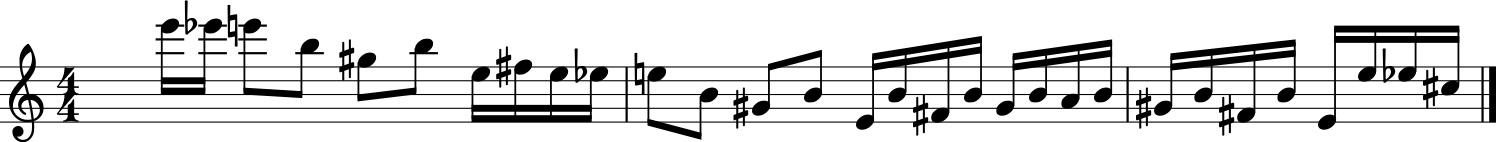

In [ ]:
seed_item.show()

In [ ]:
seed_item.play()
play_wav(seed_item.stream)

Here's what the seed sounds like:

### Start Predictions:

In [ ]:
note_temp = 1.1 #1.1 Determines amount of variation in note pitches
dur_temp = 0.4 #0.4 Amount of randomness in rhythm
top_k = 24 #24
pred, full = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

Prediction

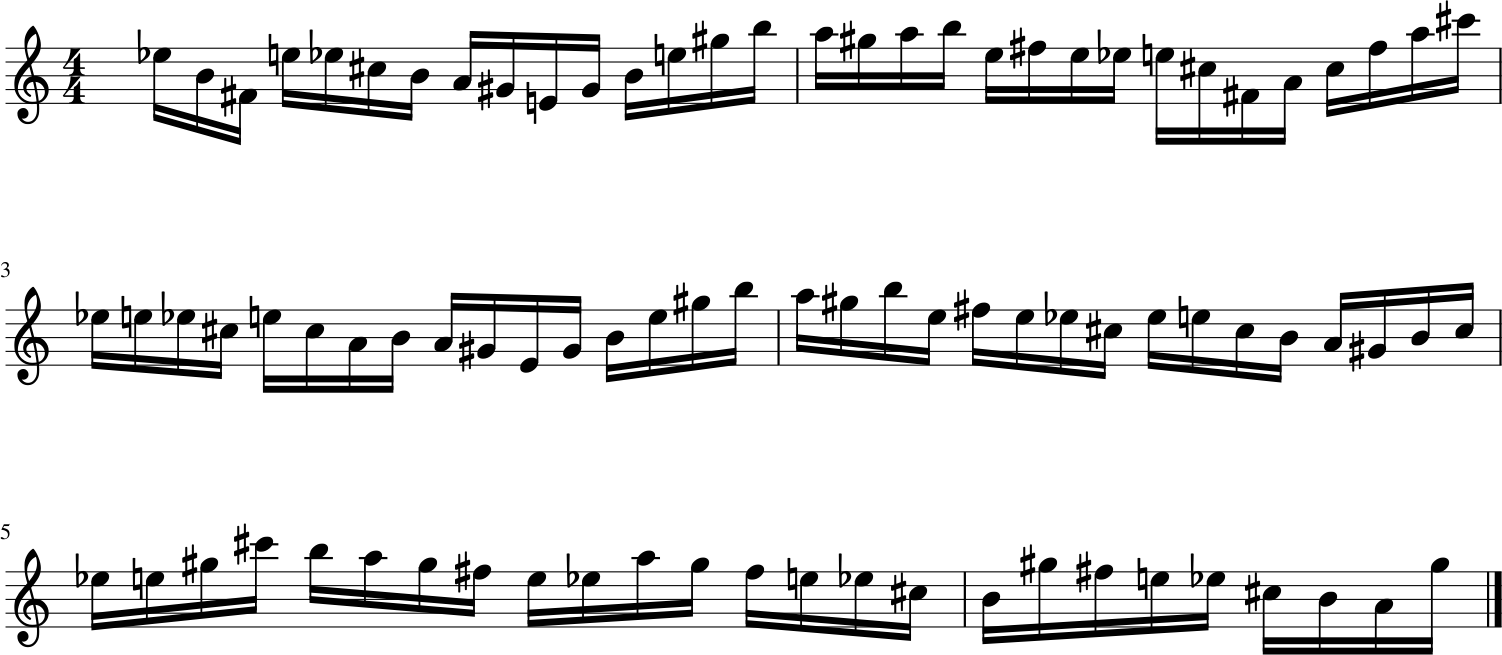

In [ ]:
# Prediction
pred.show()

In [ ]:
pred.play()
play_wav(pred.stream)

Output hidden; open in https://colab.research.google.com to view.

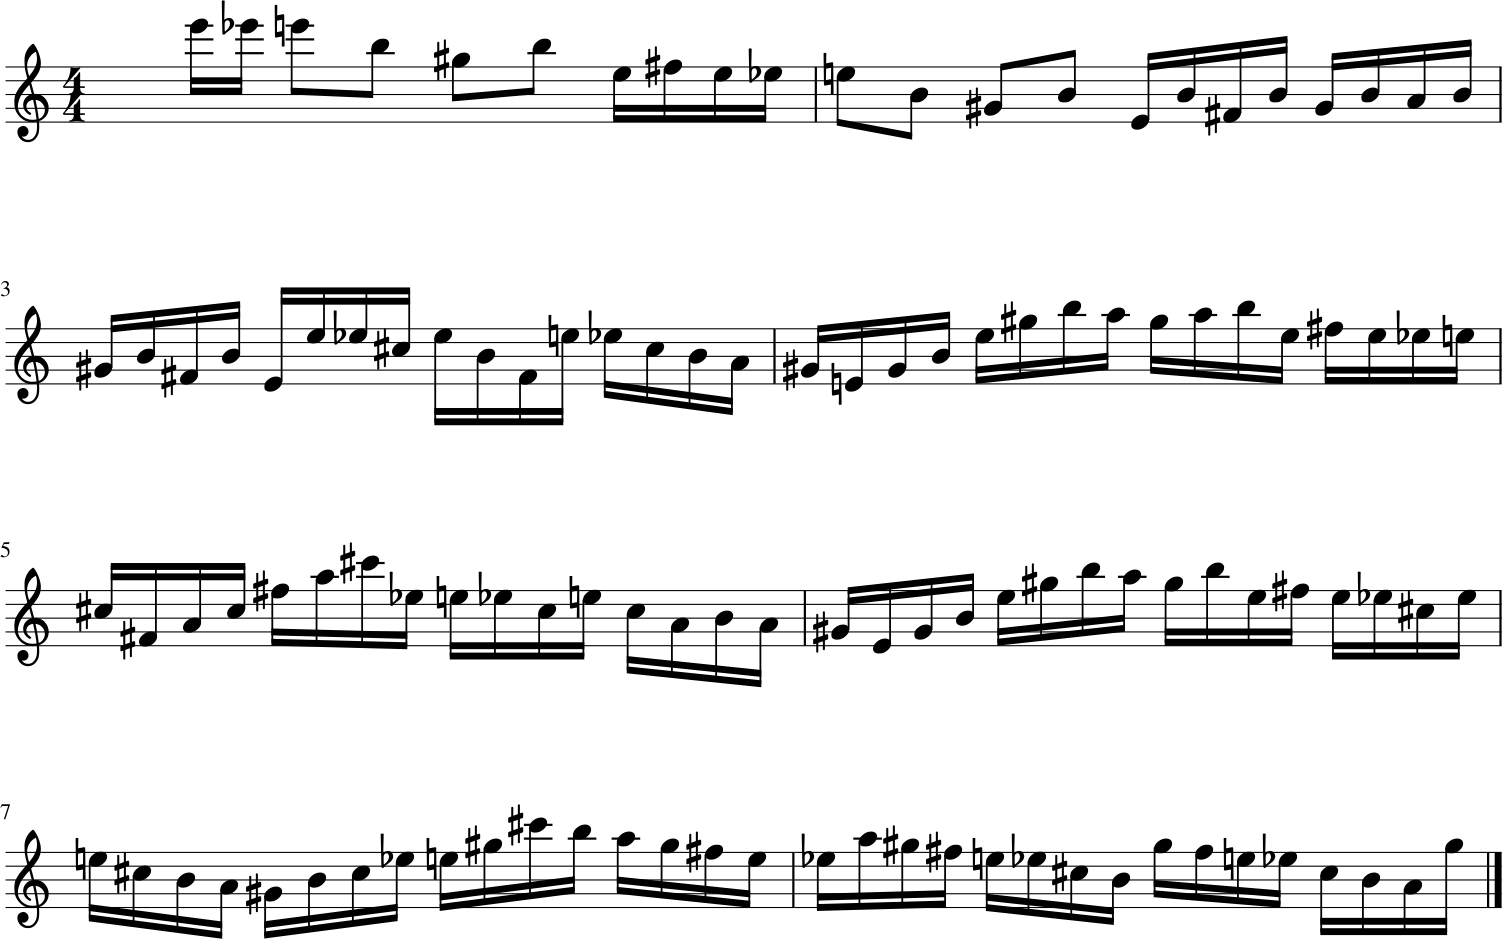

In [ ]:
full_song = seed_item.append(pred); full_song.show()

In [ ]:
full_song.play()
play_wav(full_song.stream)

Output hidden; open in https://colab.research.google.com to view.

Add more randomness to prediction

In [ ]:
note_temp = 1.4 # Determines amount of variation in note pitches
dur_temp = 0.8 # Amount of randomness in rhythm
top_k = 30
pred2, full = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

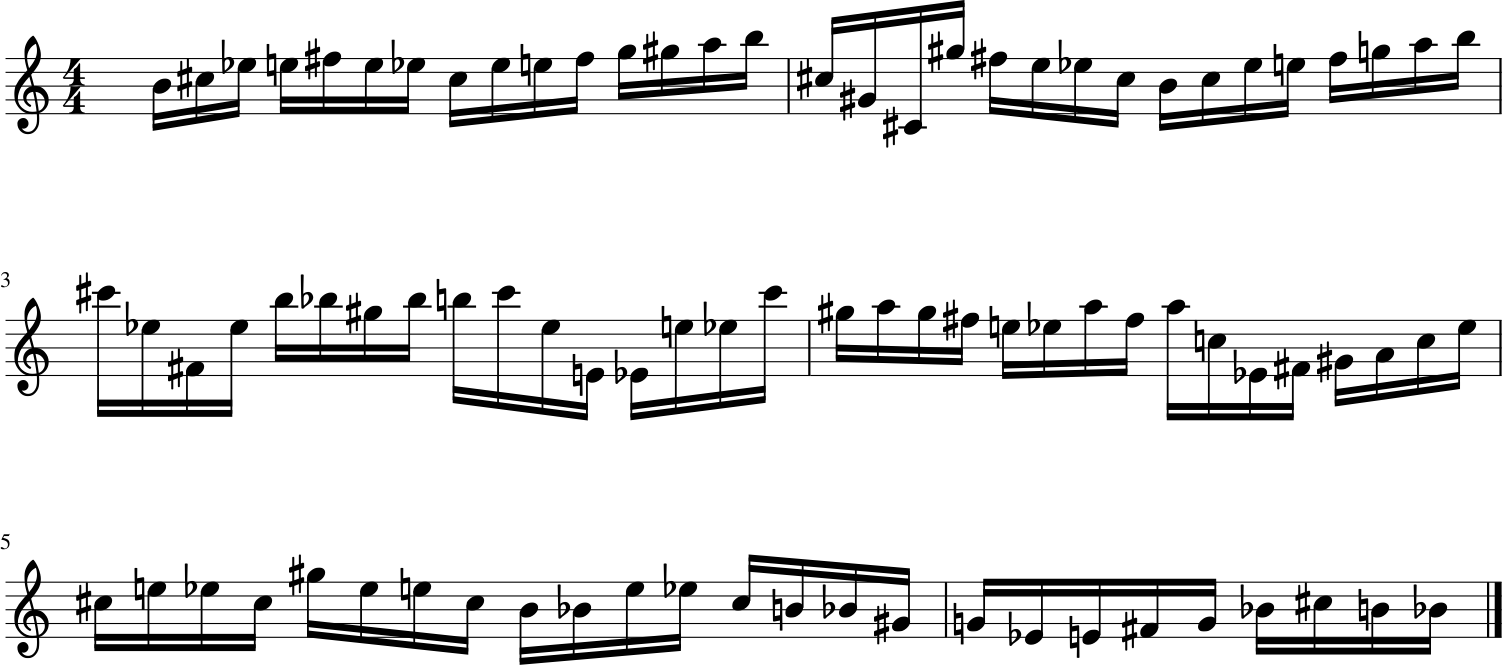

In [ ]:
pred2.show()

In [ ]:
pred2.play()
play_wav(pred2.stream)

Output hidden; open in https://colab.research.google.com to view.

Predict without a starting sequence

In [ ]:
vocab = data.vocab
empty_item = MusicItem.empty(vocab)

In [ ]:
pred3, full = learn.predict(empty_item, n_words=200)

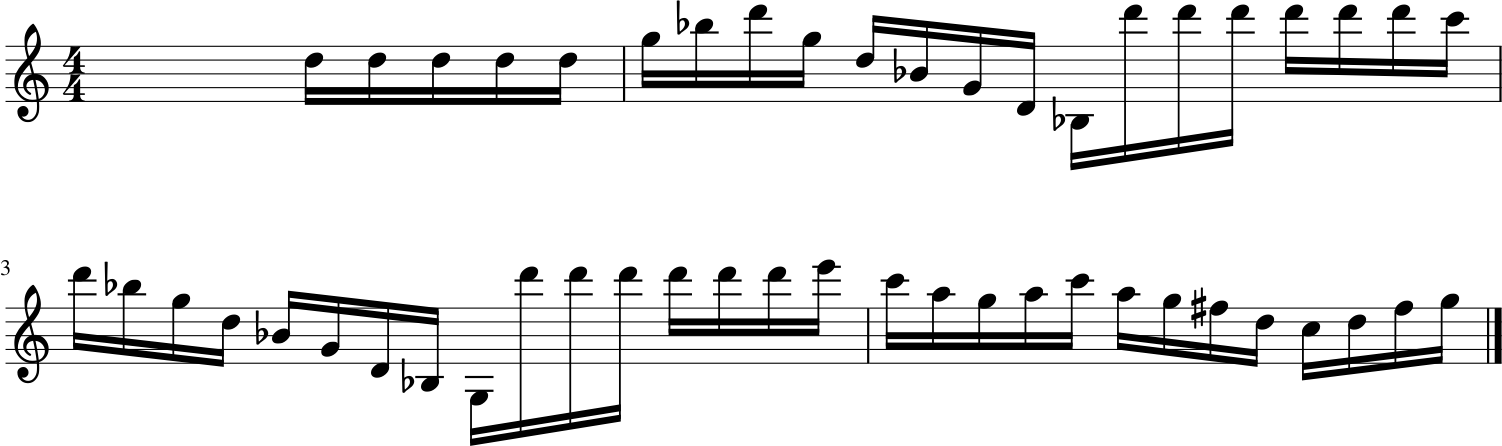

In [ ]:
pred3.show()

In [ ]:
pred3.play()
play_wav(pred3.stream)